In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
from libpysal import graph

from gwlearn.ensemble import GWRandomForestClassifier
from gwlearn.linear_model import GWLinearRegression, GWLogisticRegression
from gwlearn.search import BandwidthSearch


In [4]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
education = pd.read_csv(
    "https://martinfleischmann.net/sds/regression/data/education.csv"
)
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
independent_names = education.columns.drop(["uzemi_kod", "okres"])

In [6]:
X = education[independent_names[1:]]

In [9]:
y = elections_data["PetrPavel"]

In [12]:
search = BandwidthSearch(
    GWLinearRegression,
    fixed=True,
    geometry=elections_data.centroid,
    search_method="interval",
    min_bandwidth=10_000,
    max_bandwidth=50_000,
    interval=5_000,
    verbose=2,
)
search.fit(X, y)

Bandwidth: 10000.00, aicc: 74383.841
Bandwidth: 15000.00, aicc: 47374.149
Bandwidth: 20000.00, aicc: 43844.660
Bandwidth: 25000.00, aicc: 42977.983
Bandwidth: 30000.00, aicc: 42715.259
Bandwidth: 35000.00, aicc: 42671.022
Bandwidth: 40000.00, aicc: 42716.419
Bandwidth: 45000.00, aicc: 42804.617
Bandwidth: 50000.00, aicc: 42908.122


<Axes: >

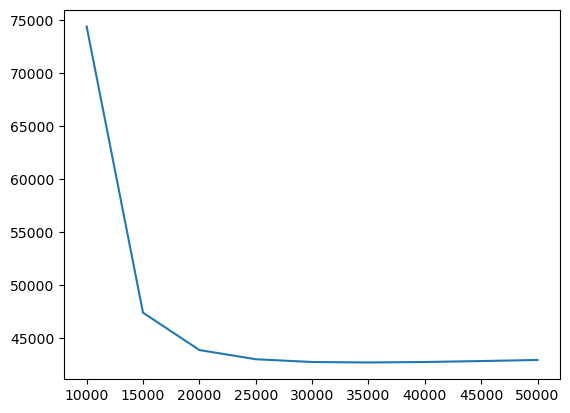

In [14]:
search.scores_.plot()

In [21]:
search_log = BandwidthSearch(
    GWLogisticRegression,
    fixed=True,
    geometry=elections_data.centroid,
    search_method="interval",
    min_bandwidth=10_000,
    max_bandwidth=50_000,
    interval=5_000,
    verbose=True,
    max_iter=1000,
    metrics=['pooled_score', 'prediction_rate']
)
search_log = search_log.fit(X, y > 50)

Bandwidth: 10000.00, aicc: 30214.473
Bandwidth: 15000.00, aicc: 10482.841
Bandwidth: 20000.00, aicc: 7243.472
Bandwidth: 25000.00, aicc: 6212.188
Bandwidth: 30000.00, aicc: 5791.596
Bandwidth: 35000.00, aicc: 5636.347
Bandwidth: 40000.00, aicc: 5594.575
Bandwidth: 45000.00, aicc: 5614.445
Bandwidth: 50000.00, aicc: 5619.761


In [22]:
search_rf = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=True,
    geometry=elections_data.centroid,
    search_method="interval",
    min_bandwidth=10_000,
    max_bandwidth=50_000,
    interval=5_000,
    verbose=True,
    metrics=['oob_score', 'prediction_rate']
)
search_rf = search_rf.fit(X, y > 50)

Bandwidth: 10000.00, aicc: nan
Bandwidth: 15000.00, aicc: nan
Bandwidth: 20000.00, aicc: nan
Bandwidth: 25000.00, aicc: 21163.229
Bandwidth: 30000.00, aicc: 11944.302
Bandwidth: 35000.00, aicc: 8478.682
Bandwidth: 40000.00, aicc: 7653.666
Bandwidth: 45000.00, aicc: 7100.347
Bandwidth: 50000.00, aicc: 6927.792


<Axes: >

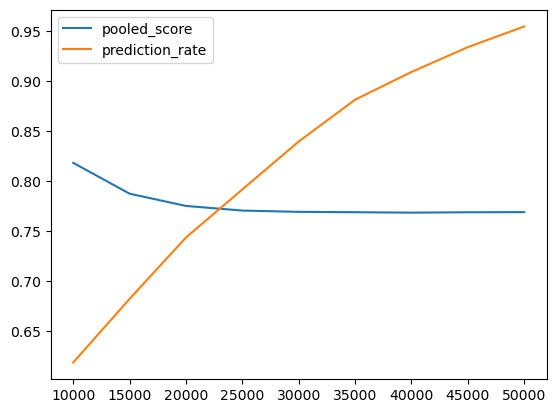

In [26]:
search_log.metrics_.plot()

<Axes: >

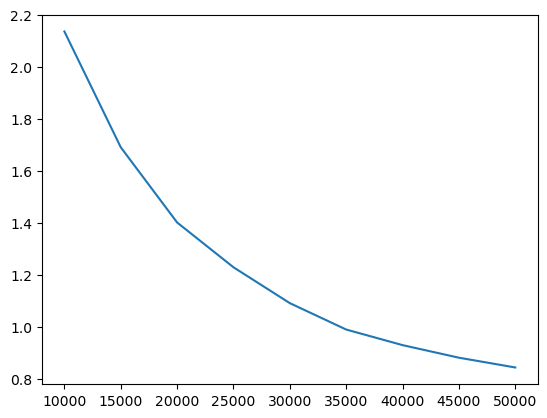

In [35]:
(search_log.metrics_['pooled_score'] / search_log.metrics_['prediction_rate'] ** 2).plot()

<Axes: >

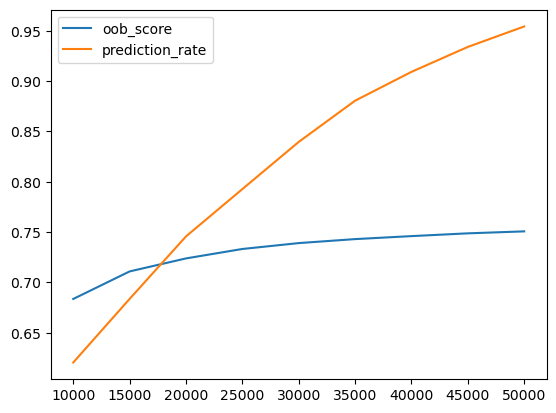

In [27]:
search_rf.metrics_.plot()

<Axes: >

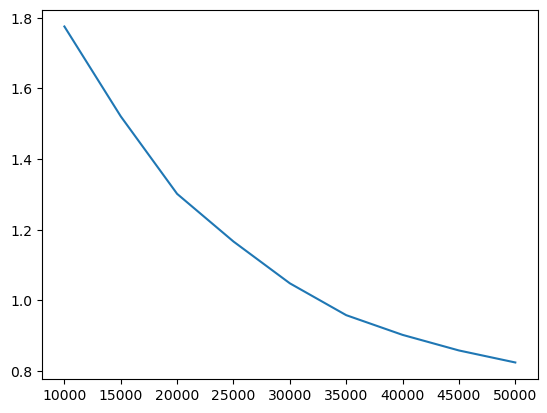

In [37]:
(search_rf.metrics_['oob_score'] / search_rf.metrics_['prediction_rate'] ** 2).plot()

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, y > 50)

RandomForestClassifier(oob_score=True)

In [42]:
rf.oob_score_

0.7406459865685961

In [43]:
search_rf.metrics_

,oob_score,prediction_rate
10000,0.683658,0.620563
15000,0.711003,0.683722
20000,0.723918,0.745763
25000,0.733286,0.792773
30000,0.739139,0.839623
35000,0.743094,0.880556
40000,0.746063,0.909178
45000,0.748818,0.933962
50000,0.750779,0.954269


In [ ]:
search_rf = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=False,
    geometry=elections_data.centroid,
    search_method="interval",
    min_bandwidth=100,
    max_bandwidth=6200,
    interval=2000,
    verbose=True,
    metrics=['oob_score', 'prediction_rate']
)
search_rf = search_rf.fit(X, y > 50)

In [44]:
X

,undetermined,incomplete_primary_education,lower_secondary_and_secondary_education,further_education,post_maturita_studies,bachelors_degree,doctoral_degree,masters_degree,higher_vocational_education,higher_vocational_education_in_a_conservatory,primary_education,complete_secondary_vocational_education,complete_secondary_general_education
0,3.741281,1.141408,34.242232,1.775523,0.507292,2.853519,0.634115,12.935954,1.395054,0.126823,11.350666,17.945466,10.779962
1,3.346457,1.968504,40.157480,2.066929,0.885827,1.771654,0.492126,6.299213,1.574803,0.000000,15.059055,16.338583,9.153543
2,3.232759,0.790230,39.152299,2.514368,0.790230,3.520115,0.215517,10.632184,1.364943,0.143678,9.770115,15.301724,12.212644
3,3.573556,1.072067,32.757594,2.084574,1.131626,3.037522,0.178678,13.281715,0.714711,0.119119,11.316260,18.701608,11.792734
4,2.890571,1.238816,34.067447,1.720578,0.757054,3.028217,0.137646,11.080523,0.894701,0.000000,9.772884,20.027529,13.971094
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249,5.645933,1.339713,38.133971,1.818182,0.622010,3.157895,0.191388,8.086124,1.148325,0.095694,11.531100,16.555024,10.956938
6250,4.534095,1.677972,35.201714,1.856480,0.892538,3.498750,0.392717,11.602999,1.392360,0.071403,10.888968,16.137094,11.138879
6251,3.337875,1.294278,35.217984,2.520436,0.681199,3.269755,0.272480,10.967302,1.430518,0.204360,10.354223,18.528610,11.648501
6252,1.903553,0.888325,32.994924,2.030457,0.507614,3.045685,1.015228,14.467005,2.538071,0.126904,11.675127,17.131980,11.421320
